In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import units
import constants_noh as constants
from scipy.integrate import quad

In [2]:
def Norm( Mvir, Rvir, r_s ):
    return Mvir / quad( lambda r: 4*np.pi*r**2 * np.exp( -2./0.17 * ( (r/r_s)**(0.17) - 1 ) ), 0, Rvir )[0]

def J_fac_int( Mvir ):
    Rvir = ( 3 * Mvir / (4*np.pi * 200 * 1.8788e-26*units.h**2*units.Kilogram/units.Meter**3) )**(1./3.)
    r_s = Rvir / cvir( Mvir )
    c = cvir(Mvir)
    #return Mvir**2 * c**3 / (12 * np.pi * Rvir**3) * ( 1 - (1+c)**(-3) ) * ( np.log(1+c) - c/(1+c) )**(-2)
    return Norm(Mvir, Rvir, r_s)**2 * quad( lambda r: 4*np.pi*r**2 * (np.exp( -2./0.17 * ( (r/r_s)**(0.17) - 1 ) ))**2, 0, Rvir )[0]

c_arr = np.array([37.5153, -1.5093, 1.636e-2, 3.66e-4, -2.89237e-5, 5.32e-7])
def cvir( Mvir ):
    cv = 0
    for ic, c in enumerate(c_arr):
        cv += c * (np.log( Mvir / (units.M_s / constants.h )))**ic
    return np.log(np.random.lognormal(cv, 0.14))

(1e-06, 1000000000000.0)

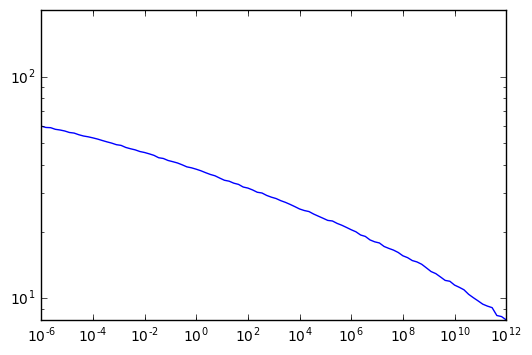

In [3]:
m_test = np.logspace( -6, 12, 100 )
plt.plot( m_test, cvir(m_test*units.M_s) )
plt.yscale("log")
plt.xscale("log")
plt.ylim(8, 200)
plt.xlim(1e-6, 1e12)

In [4]:
N_calib = 150
mMin_calib = 1e8*units.M_s
mMax_calib = 1e10*units.M_s

M_MW = 1.1e12*units.M_s
mMin_clumpy = 1e-6*units.M_s
mMin = 1e-9*M_MW
mMax = 0.01*M_MW

dNdm_norm = N_calib * (-.9) / (mMax_calib**(-.9) - mMin_calib**(-.9))

N_subs_clumpy = dNdm_norm / (-.9) * (mMax**(-.9) - mMin_clumpy**(-.9))
print(N_subs_clumpy/1e14)

N_subs = round(dNdm_norm / (-.9) * (mMax**(-.9) - mMin**(-.9)))
print(N_subs)

6.067775316223096
4423600


(0.005, 2)

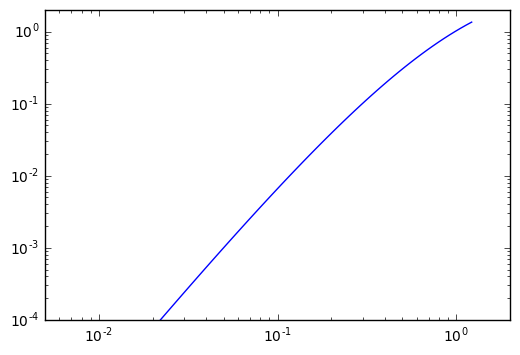

In [5]:
def UnNormSpatialDist( r ):
    return np.exp( -2/0.678 * ( (r/(199*units.kpc))**(.678) - 1 ) )

r_test = np.logspace(np.log10(1e-3*213.5), np.log10(1.22*213.5), 100)*units.kpc
y_arr = []
for rt in r_test:
    y_arr.append(quad(lambda r: r**2 * UnNormSpatialDist(r), 0, rt)[0])
y_arr = np.array(y_arr) / y_arr[ np.argmin(np.abs(r_test-213.5*units.kpc)) ]
print()
plt.plot( r_test/(213.5*units.kpc), y_arr )
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-4, 2)
plt.xlim(5e-3, 2)

In [6]:
trials = 1
rvals_sel = np.logspace(0, np.log10(260), 60000)*units.kpc
cum_r = []
for rt in rvals_sel:
    cum_r.append( quad( lambda r: r**2 * UnNormSpatialDist(r), rvals_sel[0], rt )[0] )
cum_r = np.array(cum_r)/cum_r[-1]

In [7]:
from astropy import units as u
from astropy.coordinates import SkyCoord
for trial in range(trials):
    rands = np.random.rand(N_subs)
    rval_arr = np.interp( rands, cum_r, rvals_sel )
    rands = np.random.rand(N_subs)
    mval_arr = (mMin**(-.9) + rands*(mMax**(-.9) - mMin**(-.9)))**(-1/.9)
    theta_arr = np.arccos( 2*np.random.rand(N_subs) - 1 )
    phi_arr = 2*np.pi*np.random.rand(N_subs)
    
    PS_list = SkyCoord(x=rval_arr*np.cos(phi_arr)*np.sin(theta_arr)/units.kpc*u.kpc, 
                       y=rval_arr*np.sin(phi_arr)*np.sin(theta_arr)/units.kpc*u.kpc,
                       z=rval_arr*np.cos(theta_arr)/units.kpc*u.kpc, frame="galactocentric").transform_to("galactic")
    
    dA_arr = PS_list.distance.value*units.kpc
    J_arr = []
    for i in range(N_subs):
        J_arr.append(J_fac_int( mval_arr[i] ) / dA_arr[i]**2 / (units.Centimeter**(-5) * units.GeV**2))

(1e+17, 1e+22)

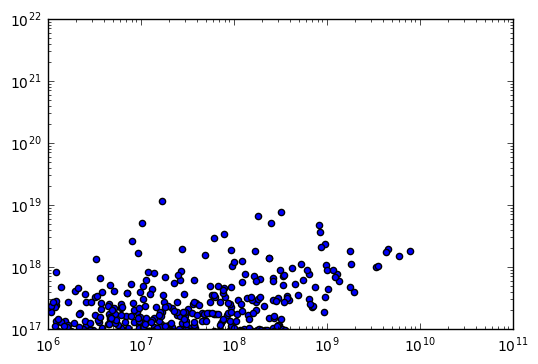

In [8]:
plt.scatter(mval_arr/units.M_s, J_arr)
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e6, 1e11)
plt.ylim(1e17, 1e22)

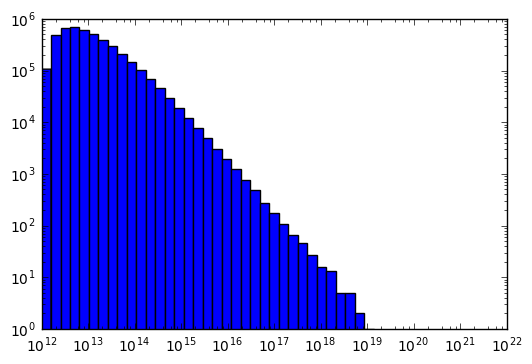

In [9]:
bins = plt.hist(J_arr, bins=np.logspace(12,22,50))
N = np.sum(bins[0])
cum_J = []
for val in bins[0]:
    cum_J.append(N)
    N=N-val
plt.yscale("log")
plt.xscale("log")

(5e+16, 3e+21)

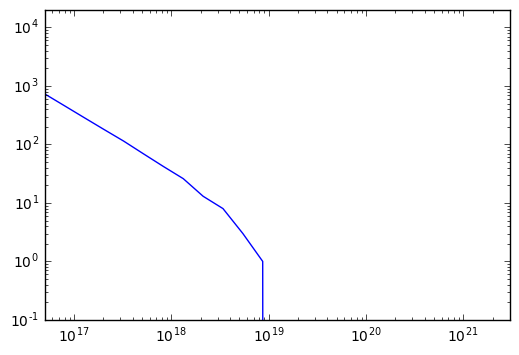

In [10]:
plt.plot(bins[1][:-1], cum_J)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-1, 2e4)
plt.xlim(5e16, 3e21)

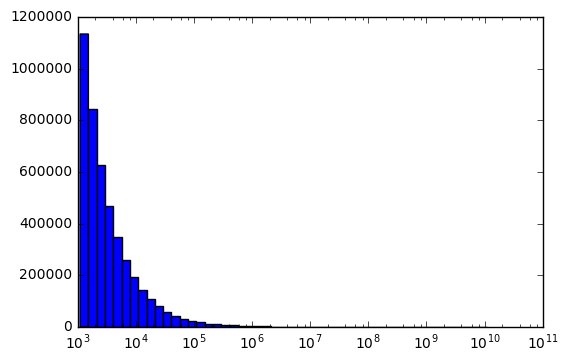

In [11]:
plt.hist((mval_arr)/units.M_s, bins=np.logspace(np.log10(mMin/units.M_s), np.log10(mMax/units.M_s), 50));
plt.xscale("log")